In [225]:
# Carga de paquetes necesarios para graficar
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # Para leer archivos
import geopandas as gpd # Para hacer cosas geográficas
import seaborn as sns # Para hacer plots lindos
import networkx as nx # Construcción de la red en NetworkX
import scipy

# Preambulo

En esta sección cargamos los datos y los visualizamos. También construimos la matriz de adyacencia de la red de museos.

## Carga de datos de los museos

El listado de los museos, con el que se construye el [mapa](https://mapas.museosabiertos.org/museos/caba/), lo podemos encontrar [acá](https://github.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/blob/principal/data/export.geojson?short_path=bc357f3). También descargamos los barrios de CABA como complemento para los gráficos.

In [226]:
# Leemos el archivo, retenemos aquellos museos que están en CABA, y descartamos aquellos que no tienen latitud y longitud
museos = gpd.read_file('https://raw.githubusercontent.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/refs/heads/principal/data/export.geojson')
barrios = gpd.read_file('https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-educacion/barrios/barrios.geojson')

## Visualización

<Axes: >

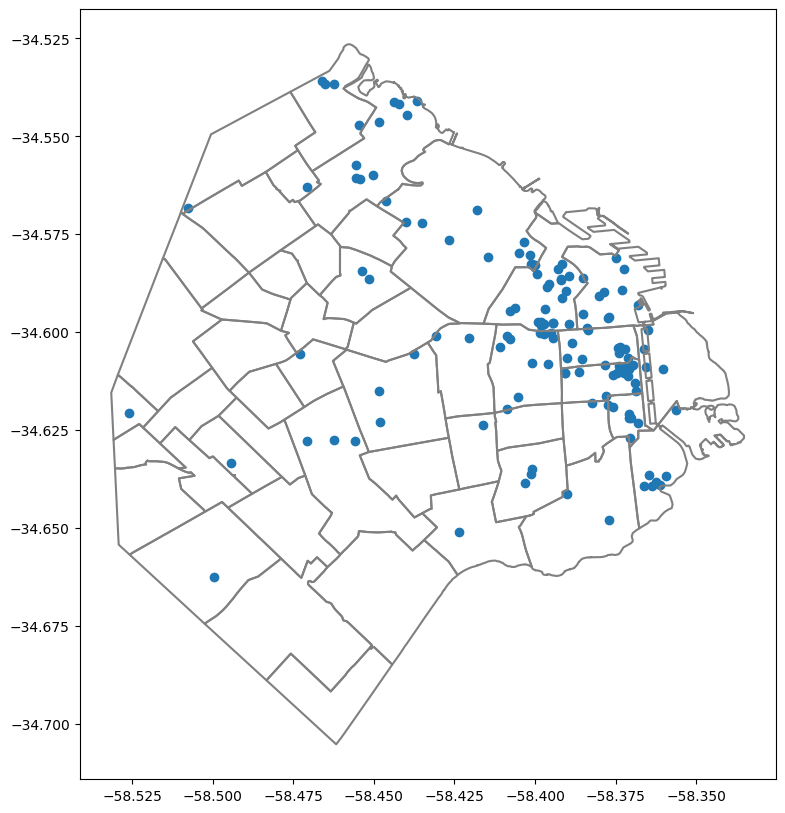

In [227]:
# Armamos el gráfico para visualizar los museos
fig, ax = plt.subplots(figsize=(10, 10))
barrios.boundary.plot(color='gray',ax=ax)
museos.plot(ax=ax)

## Cálculo de la matriz de distancias

Ahora construimos la matriz de distancias entre todos los museos. Como la tierra es un [geoide](https://es.wikipedia.org/wiki/Geoide) (es decir que no es [plana](https://es.wikipedia.org/wiki/Terraplanismo)), el cálculo de distancias no es una operación obvia. Una opción es proyectar a un [sistema de coordenadas local](https://geopandas.org/en/stable/docs/user_guide/projections.html), de forma tal que las distancias euclideas se correspondan con las distancias en metros. En este notebook usamos [EPSG](https://en.wikipedia.org/wiki/EPSG_Geodetic_Parameter_Dataset) 22184. 

In [228]:
# En esta línea:
# Tomamos museos, lo convertimos al sistema de coordenadas de interés, extraemos su geometría (los puntos del mapa), 
# calculamos sus distancias a los otros puntos de df, redondeamos (obteniendo distancia en metros), y lo convertimos a un array 2D de numpy
D = museos.to_crs("EPSG:22184").geometry.apply(lambda g: museos.to_crs("EPSG:22184").distance(g)).round().to_numpy()

### Matriz de adyacencia: construimos una matriz conectando a cada museo con los $m$ más cercanos

In [229]:
def construye_adyacencia(D,m): 
    # Función que construye la matriz de adyacencia del grafo de museos
    # D matriz de distancias, m cantidad de links por nodo
    # Retorna la matriz de adyacencia como un numpy.
    D = D.copy()
    l = [] # Lista para guardar las filas
    for fila in D: # recorriendo las filas, anexamos vectores lógicos
        l.append(fila<=fila[np.argsort(fila)[m]] ) # En realidad, elegimos todos los nodos que estén a una distancia menor o igual a la del m-esimo más cercano
    A = np.asarray(l).astype(int) # Convertimos a entero
    np.fill_diagonal(A,0) # Borramos diagonal para eliminar autolinks
    return(A)

m = 3 # Cantidad de links por nodo
A = construye_adyacencia(D,m)

## Construcción de la red en NetworkX (sólo para las visualizaciones)

In [230]:
G = nx.from_numpy_array(A) # Construimos la red a partir de la matriz de adyacencia
# Construimos un layout a partir de las coordenadas geográficas
G_layout = {i:v for i,v in enumerate(zip(museos.to_crs("EPSG:22184").get_coordinates()['x'],museos.to_crs("EPSG:22184").get_coordinates()['y']))}

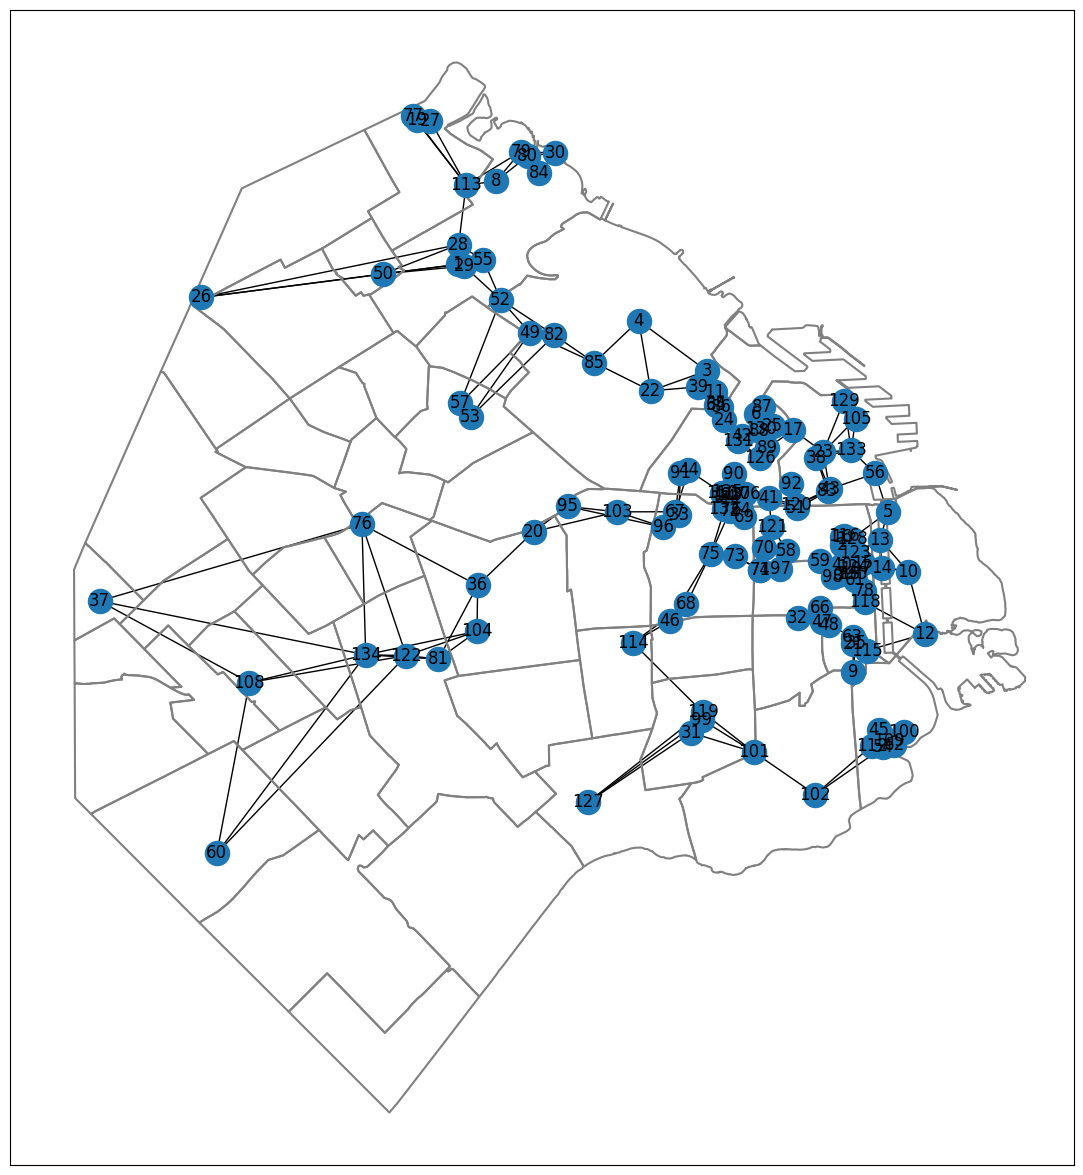

In [231]:
fig, ax = plt.subplots(figsize=(15, 15)) # Visualización de la red en el mapa
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
nx.draw_networkx(G,G_layout,ax=ax) # Graficamos los museos

# Resolución del TP

## Punto 1: 
----
Partiendo de la ecuación

$$
\mathbf{p} = (1-\alpha) C \mathbf{p} + \frac{\alpha}{N} \mathbf{1}
$$

muestre que el vector de rankings **p** es solución de la ecuación     $M\mathbf{p} = \mathbf{b}$  , con    $M = \frac{N}{\alpha}(I - (1-\alpha)C)$    y    $\mathbf{b} = \mathbf{1}$  .


### Resolución

La ecuación es:

$$
\mathbf{p} = (1-\alpha)C\mathbf{p} + \frac{\alpha}{N}\mathbf{1},
$$

luego:

$$\mathbf{p} - (1-\alpha)C\mathbf{p} = \frac{\alpha}{N}\mathbf{1}$$

equivale a

$$\mathbf{p}I - (1-\alpha)C\mathbf{p} = \frac{\alpha}{N}\mathbf{1}$$

equivale a

$$(I - (1-\alpha)C)\mathbf{p} = \frac{\alpha}{N}\mathbf{1}$$

equivale a

$$\frac{N}{\alpha}(I - (1-\alpha)C)\mathbf{p} = \mathbf{1}$$

y con $M = \frac{N}{\alpha}(I - (1-\alpha)C)$ resulta lo pedido: $M\mathbf{p} = \mathbf{b} = \mathbf{1}$.


## Punto 2:
----
¿Qué condiciones se deben cumplir para que exista una única solución a la ecuación del
punto anterior? ¿Se cumplen estas condiciones para la matriz $M$ tal como fue construida
para los museos, cuando $0 < \alpha < 1$? Demuestre que se cumplen o dé un contraejemplo.


Dado el ítem anterior, la ecuación $Mp = 1$ tendrá solución única cuando $M$ sea inversible. Una condición necesaria y suficiente para esto es que el núcleo de $M$ sea $\{0\}$.

Primero, usando el tip dado en clase, pruebo:

$$
\text{Si} \quad B \in \mathbb{R}^{n \times n} \quad \text{y} \quad \|B\|_1 < 1 \quad \text{entonces} \quad (I-B) \quad \text{es inversible}.
$$

Supongamos que existe $(I-B)^{-1}$. Entonces, si existiera $x \neq 0$ en $\mathbb{R}^{n}$ tal que $(I-B)x = 0$, tendríamos:

$$
x - Bx = 0
$$

lo que equivale a

$$
x = Bx.
$$

Uso la norma-1 (que preserva la igualdad) y puedo suponer que $\|x\|_1 = 1$. Entonces:

$$
\|x\|_1 = \|Bx\|_1 \quad \Rightarrow \quad 1 = \|Bx\|_1.
$$

Además, se cumple que $\|Bx\|_1 \leq \|B\|_1 \|x\|_1$ y, usando la hipótesis $\|B\|_1 < 1$, resulta:

$$
\|Bx\|_1 \leq \|B\|_1 \|x\|_1 = \|B\|_1 < 1.
$$

Por lo tanto, tenemos que:

$$
\|Bx\|_1 = 1 \quad \text{y} \quad \|Bx\|_1 < 1,
$$

lo cual es imposible. Como lo único que supusimos fue que $x \neq 0$, debe ser entonces que solamente se cumple $(I-B)x = 0$ si $x = 0$. Por lo tanto, $(I-B)$ es inversible.

---

Volviendo al problema original: $Mp = 1$ tendrá solución única si la matriz $M$ resulta inversible, es decir, si $(I - (1-\alpha)C)$ es inversible.

Por un lado, observamos que $\|C\|_1 = 1$ dado que, por definición, sus columnas suman 1. Por otro lado, como $0 < \alpha < 1$, se cumple que $1-\alpha < 1$.

Es decir:

$$
\|(1-\alpha)C\|_1 = (1-\alpha)\|C\|_1 < 1.
$$

Esto es análogo al problema anterior sobre la existencia de $(I-B)^{-1}$, por lo tanto $(I - (1-\alpha)C)^{-1}$ existe, y la solución $p$ es única con la matriz $M$ y $\alpha$ así definidos.


## Punto 3:
----
Usando la factorización $LU$ implementada, encuentre el vector $\mathbf{p} = M^{-1} \mathbf{b}$ en los siguientes casos:

**a.** Construyendo la red conectando a cada museo con sus $m = 3$ vecinos más cercanos, calculen el Page Rank usando $\alpha = 1/5$. Visualicen la red asignando un tamaño a cada nodo proporcional al Page Rank que le toca.

**b.** Construyendo la red conectando a cada museo con sus $m$ vecinos más cercanos, para $m = 1, 3, 5, 10$ y usando $\alpha = 1/

**c.** Para $m = 5$, considerando los valores de $\alpha = 6/7, 4/5, 2/3, 1/2, 1/3, 1/5, 1/7$

-----

Usando los valores de $\mathbf{p}$ obtenidos para cada caso,

**a.** Identifiquen los 3 museos más centrales (para cada $m$ y cada $\alpha$) y grafiquen sus puntajes (valores de Page Rank) en función del parámetro a variar (es decir, en función de $m$ o de $\alpha$). ¿Son estables las posiciones en el ranking? Describa los distintos patrones que observa, identificando qué ubicaciones son relevantes en cada caso. ¿Hay museos que sólo son relevantes en redes con pocas conexiones? ¿O museos que se vuelven más relevantes mientras más conexiones aparecen?

**b.** Construyan visualizaciones del mapa, usando el Page Rank para representar el tamaño de cada museo. ¿Qué regiones se vuelven más predominantes al aumentar $\alpha$? ¿Y al aumentar $m$?


In [232]:
import importlib
import numpy as np
import matplotlib.pyplot as plt
import template_funciones as tf
from IPython.display import display
importlib.reload(tf)

<module 'template_funciones' from 'c:\\Users\\mazze\\OneDrive\\Documentos\\GIT\\ALC2025-1c-TP1\\template_funciones.py'>

In [233]:
# 1. Construimos matrices de adyacencia para distintos m
A_m1 = construye_adyacencia(D, 1)
A_m3 = construye_adyacencia(D, 3)
A_m5 = construye_adyacencia(D, 5)
A_m10 = construye_adyacencia(D, 10)

In [234]:
# 2. Construimos grafos para distintos m
G_m1 = nx.from_numpy_array(A_m1)
G_m3 = nx.from_numpy_array(A_m3)
G_m5 = nx.from_numpy_array(A_m5)
G_m10 = nx.from_numpy_array(A_m10)

In [235]:
# 3. Construimos layout (mismo para todos)
coords = museos.to_crs("EPSG:22184").get_coordinates()
G_layout = {i: (x, y) for i, (x, y) in enumerate(zip(coords['x'], coords['y']))}

In [236]:
# 4. Calculamos todos los PageRank
# Para distintos m (con alfa fijo 1/5)
alfa = 1/5
p_m1 = tf.calcula_pagerank(A_m1, alfa)
p_m3 = tf.calcula_pagerank(A_m3, alfa)
p_m5 = tf.calcula_pagerank(A_m5, alfa)
p_m10 = tf.calcula_pagerank(A_m10, alfa)

# Para m=5 fijo y distintos alfa
p_a67 = tf.calcula_pagerank(A_m5, 6/7)
p_a45 = tf.calcula_pagerank(A_m5, 4/5)
p_a23 = tf.calcula_pagerank(A_m5, 2/3)
p_a12 = tf.calcula_pagerank(A_m5, 1/2)
p_a13 = tf.calcula_pagerank(A_m5, 1/3)
p_a15 = tf.calcula_pagerank(A_m5, 1/5)
p_a17 = tf.calcula_pagerank(A_m5, 1/7)

Veamos primero qué pasa al dejar fijo $\alpha = 1/5$, y variar $m$:

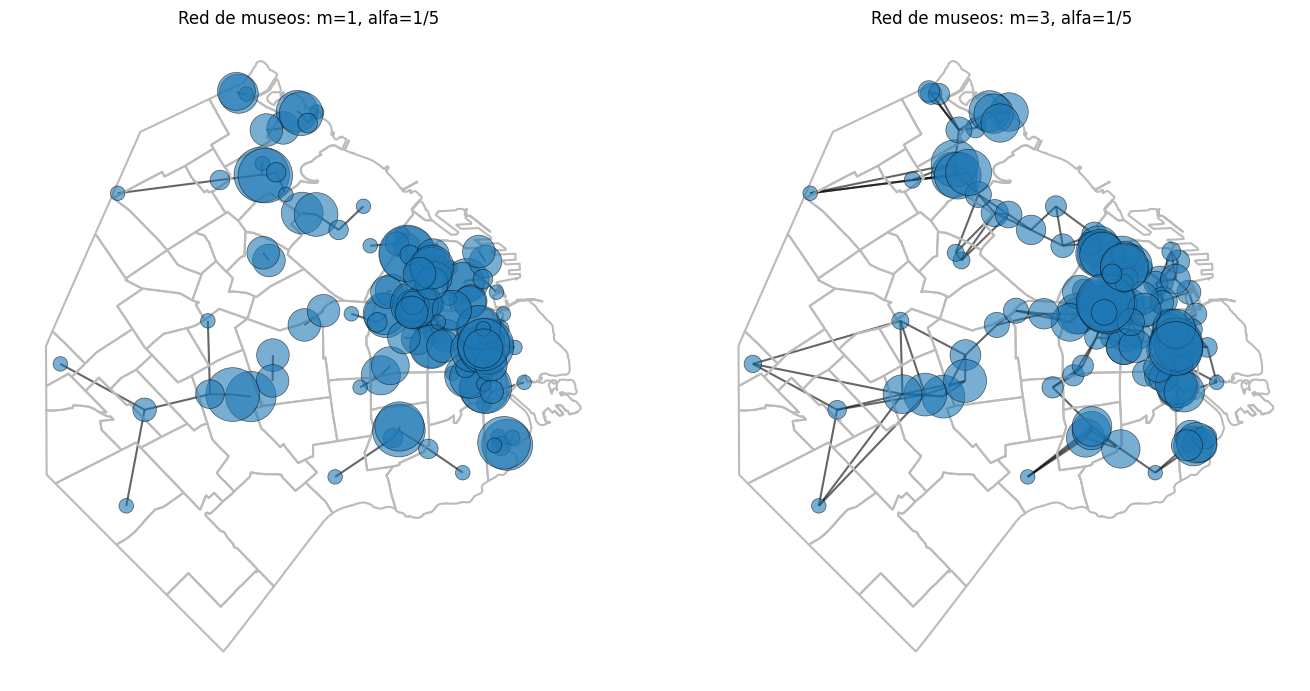

In [237]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

tf.graficar_red_museos(G_m1, G_layout, barrios, p_m1, "Red de museos: m=1, alfa=1/5", ax=ax1)
tf.graficar_red_museos(G_m3, G_layout, barrios, p_m3, "Red de museos: m=3, alfa=1/5", ax=ax2)

plt.tight_layout()
plt.show()

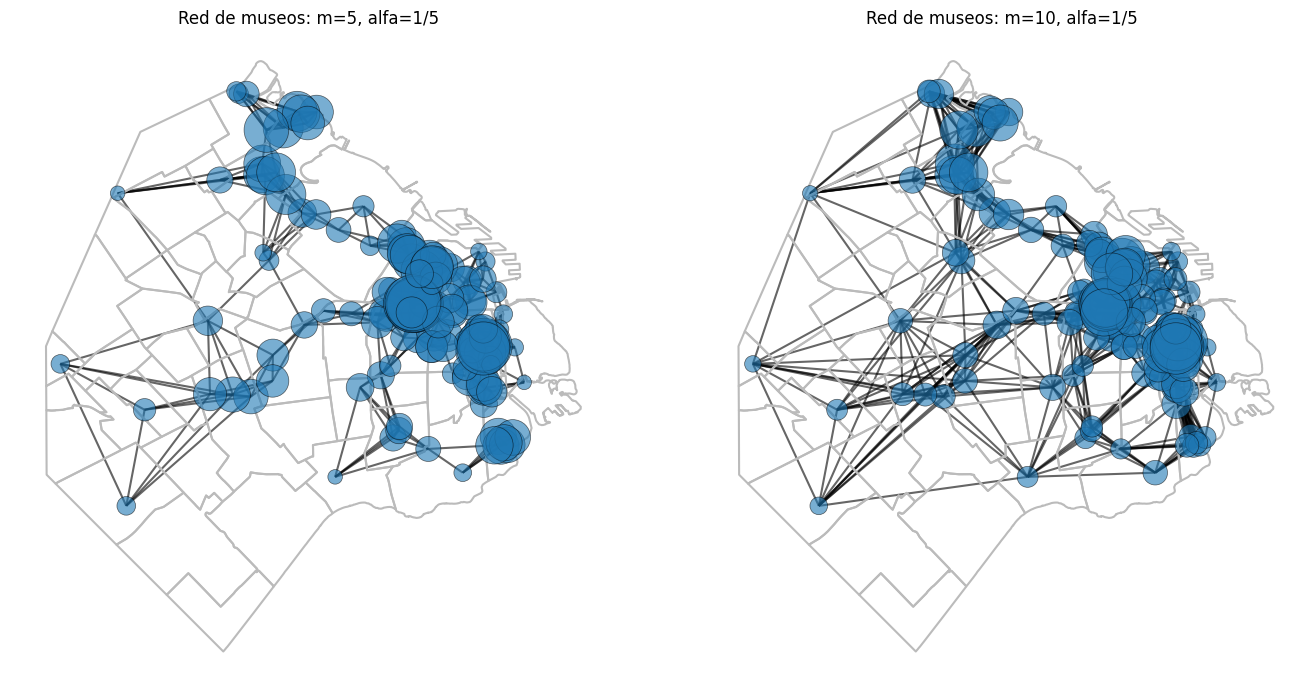

In [238]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

tf.graficar_red_museos(G_m5, G_layout, barrios, p_m5, "Red de museos: m=5, alfa=1/5", ax=ax1)
tf.graficar_red_museos(G_m10, G_layout, barrios, p_m10, "Red de museos: m=10, alfa=1/5", ax=ax2)

plt.tight_layout()
plt.show()

Ahora dejaremos fijo $m=5$ y variaremos $\alpha$:

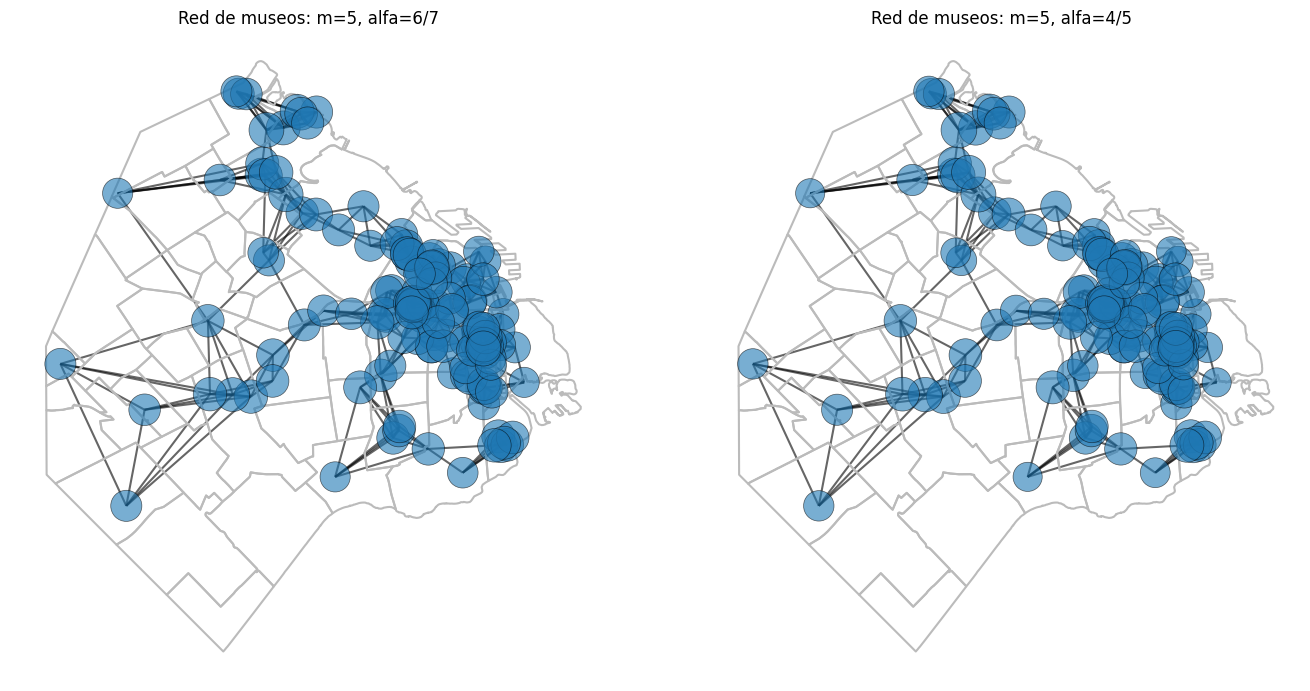

In [239]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

tf.graficar_red_museos(G_m5, G_layout, barrios, p_a67, "Red de museos: m=5, alfa=6/7", ax=ax1)
tf.graficar_red_museos(G_m5, G_layout, barrios, p_a45, "Red de museos: m=5, alfa=4/5", ax=ax2)

plt.tight_layout()
plt.show()

Podemos ver que la red se mantiene, sin embargo, el tamaño de los puntos es mucho más parecido, es decir, tienen todos casi la misma importancia cuando $\alpha$ está cerca de uno.

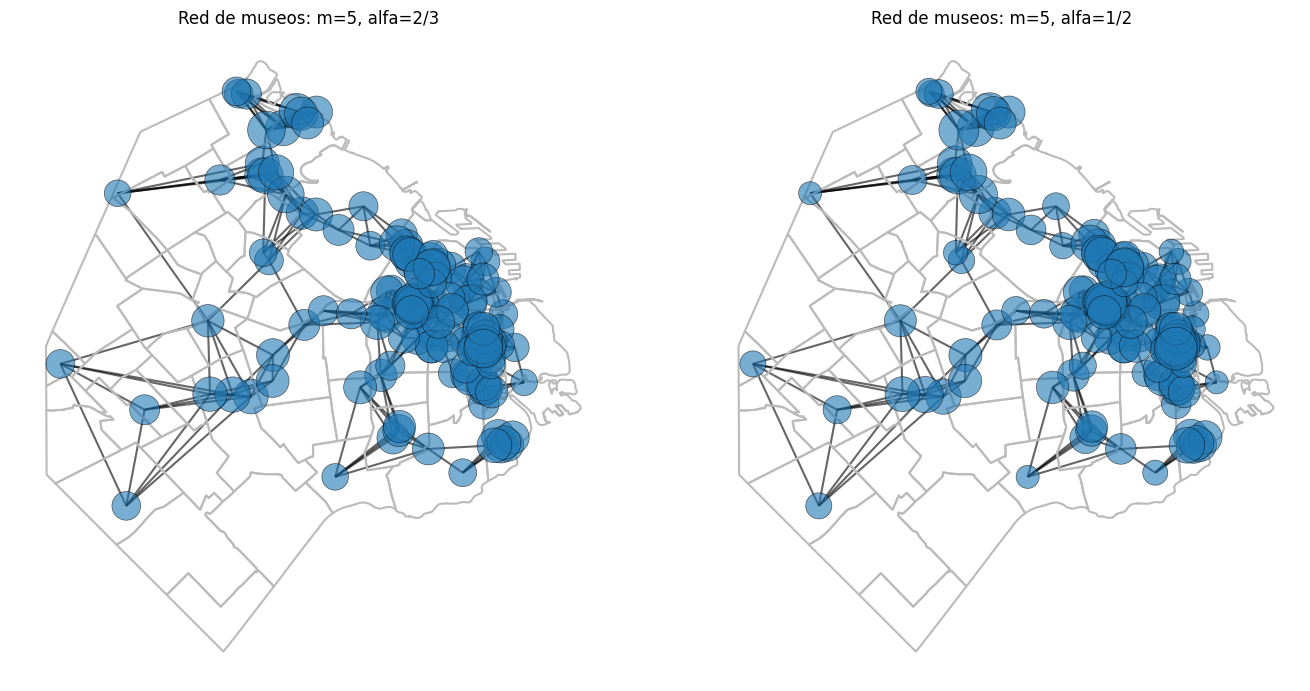

In [240]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

tf.graficar_red_museos(G_m5, G_layout, barrios, p_a23, "Red de museos: m=5, alfa=2/3", ax=ax1)
tf.graficar_red_museos(G_m5, G_layout, barrios, p_a12, "Red de museos: m=5, alfa=1/2", ax=ax2)

plt.tight_layout()
plt.show()

A medida que $\alpha$ se aleja de $1$ y se acerca a $0$ el tamaño de los puntos se hace más dispar, pasando a ser más relevante la cercanía entre los museos.

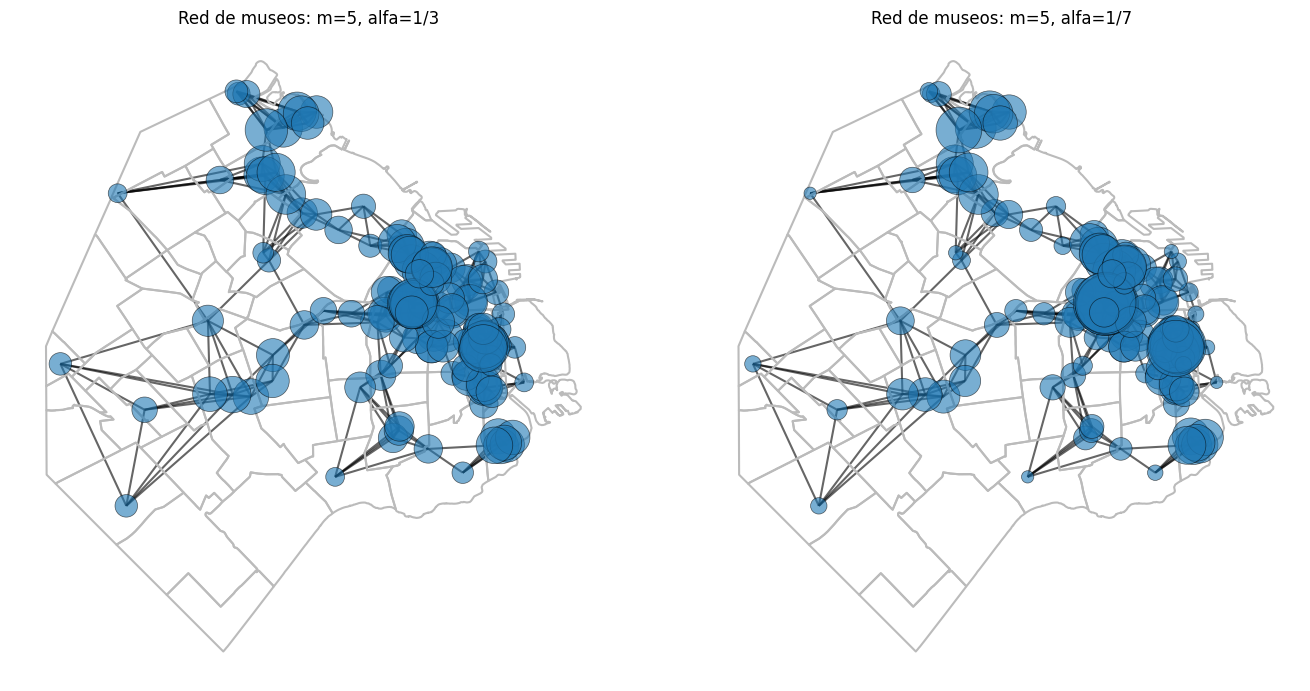

In [241]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

tf.graficar_red_museos(G_m5, G_layout, barrios, p_a13, "Red de museos: m=5, alfa=1/3", ax=ax1)
tf.graficar_red_museos(G_m5, G_layout, barrios, p_a17, "Red de museos: m=5, alfa=1/7", ax=ax2)

plt.tight_layout()
plt.show()

In [242]:
# Para la segunda parte, primero guardaremos los valores de p en diccionarios
# Resultados con alfa = 1/5 y m variable
resultados_m = {
    1: p_m1,
    3: p_m3,
    5: p_m5,
    10: p_m10
}

# Resultados con m = 5 y alfa variable
resultados_alfa = {
    "6/7": p_a67,
    "4/5": p_a45,
    "2/3": p_a23,
    "1/2": p_a12,
    "1/3": p_a13,
    "1/5": p_a15,
    "1/7": p_a17
}

In [243]:
# Primero buscamos el Top 3 haciendo variar m

valores_m = [1, 3, 5, 10]
top1_m = []
top2_m = []
top3_m = []

for m, p in resultados_m.items():
    print(f"\nTop 3 museos para m = {m} y alfa fijo en 1/5:")
    p_copy = p.copy()

    top_vals = []

    # Top 3
    for i in range(3):
        max_val = -1
        max_idx = -1

        # Recorremos p_copy para buscar el maximo y su posicion
        for idx in range(len(p_copy)):
            if p_copy[idx] > max_val:
                max_val = p_copy[idx]
                max_idx = idx
        
        print(f"{i+1}° → Museo #{max_idx} con PageRank = {max_val:.4f}")
        
        # Lo sacamos para encontrar el resto del Top
        p_copy[max_idx] = -1
        top_vals.append(max_val)

    top1_m.append(top_vals[0])
    top2_m.append(top_vals[1])
    top3_m.append(top_vals[2])


Top 3 museos para m = 1 y alfa fijo en 1/5:
1° → Museo #65 con PageRank = 0.0221
2° → Museo #107 con PageRank = 0.0217
3° → Museo #34 con PageRank = 0.0213

Top 3 museos para m = 3 y alfa fijo en 1/5:
1° → Museo #117 con PageRank = 0.0241
2° → Museo #125 con PageRank = 0.0235
3° → Museo #18 con PageRank = 0.0213

Top 3 museos para m = 5 y alfa fijo en 1/5:
1° → Museo #93 con PageRank = 0.0217
2° → Museo #125 con PageRank = 0.0216
3° → Museo #117 con PageRank = 0.0211

Top 3 museos para m = 10 y alfa fijo en 1/5:
1° → Museo #124 con PageRank = 0.0187
2° → Museo #135 con PageRank = 0.0183
3° → Museo #15 con PageRank = 0.0183


In [244]:
# Hacemos lo mismo haciendo variar alfa

valores_alfa = ["6/7", "4/5", "2/3", "1/2", "1/3", "1/5", "1/7"]
top1_alfa = []
top2_alfa = []
top3_alfa = []

for alfa, p in resultados_alfa.items():
    print(f"\nTop 3 museos para alfa = {alfa} y m fijo en 5:")
    p_copy = p.copy()
    
    top_vals = []

    # Top 3
    for i in range(3):
        max_val = -1
        max_idx = -1

        # Recorremos p_copy para buscar el maximo y su posicion
        for idx in range(len(p_copy)):
            if p_copy[idx] > max_val:
                max_val = p_copy[idx]
                max_idx = idx
        
        print(f"{i+1}° → Museo #{max_idx} con PageRank = {max_val:.4f}")
        
        # Lo sacamos para encontrar el resto del Top
        p_copy[max_idx] = -1
        top_vals.append(max_val)

    top1_alfa.append(top_vals[0])
    top2_alfa.append(top_vals[1])
    top3_alfa.append(top_vals[2])


Top 3 museos para alfa = 6/7 y m fijo en 5:
1° → Museo #107 con PageRank = 0.0087
2° → Museo #18 con PageRank = 0.0085
3° → Museo #135 con PageRank = 0.0085

Top 3 museos para alfa = 4/5 y m fijo en 5:
1° → Museo #107 con PageRank = 0.0093
2° → Museo #18 con PageRank = 0.0090
3° → Museo #135 con PageRank = 0.0090

Top 3 museos para alfa = 2/3 y m fijo en 5:
1° → Museo #107 con PageRank = 0.0107
2° → Museo #135 con PageRank = 0.0104
3° → Museo #18 con PageRank = 0.0104

Top 3 museos para alfa = 1/2 y m fijo en 5:
1° → Museo #107 con PageRank = 0.0129
2° → Museo #93 con PageRank = 0.0126
3° → Museo #135 con PageRank = 0.0126

Top 3 museos para alfa = 1/3 y m fijo en 5:
1° → Museo #93 con PageRank = 0.0162
2° → Museo #125 con PageRank = 0.0161
3° → Museo #107 con PageRank = 0.0158

Top 3 museos para alfa = 1/5 y m fijo en 5:
1° → Museo #93 con PageRank = 0.0217
2° → Museo #125 con PageRank = 0.0216
3° → Museo #117 con PageRank = 0.0211

Top 3 museos para alfa = 1/7 y m fijo en 5:
1° → Mu

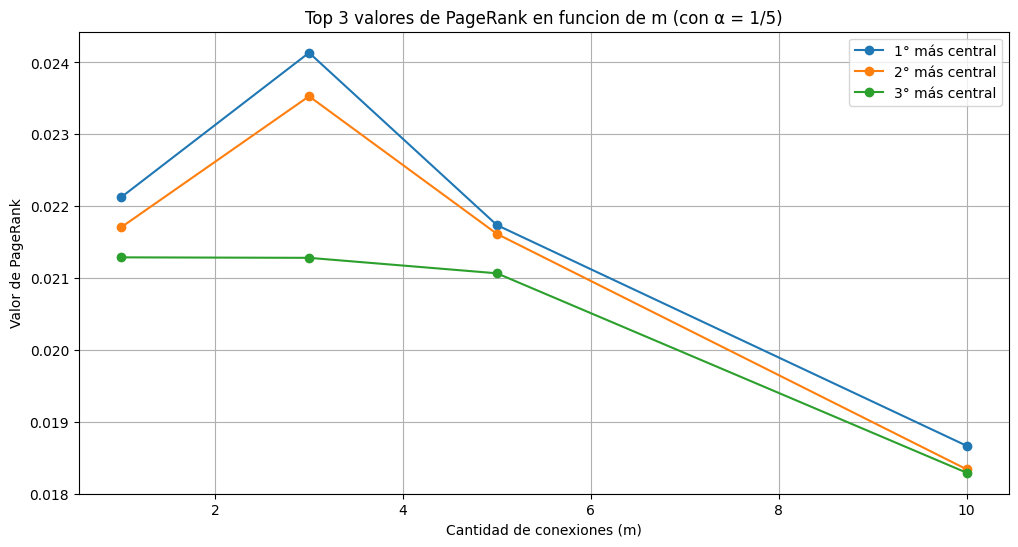

In [245]:
# Con todo listo pasamos a graficar

plt.figure(figsize=(12,6))
plt.plot(valores_m, top1_m, marker='o', label='1° más central')
plt.plot(valores_m, top2_m, marker='o', label='2° más central')
plt.plot(valores_m, top3_m, marker='o', label='3° más central')
plt.xlabel("Cantidad de conexiones (m)")
plt.ylabel("Valor de PageRank")
plt.title("Top 3 valores de PageRank en funcion de m (con α = 1/5)")
plt.grid(True)
plt.legend()
plt.show()

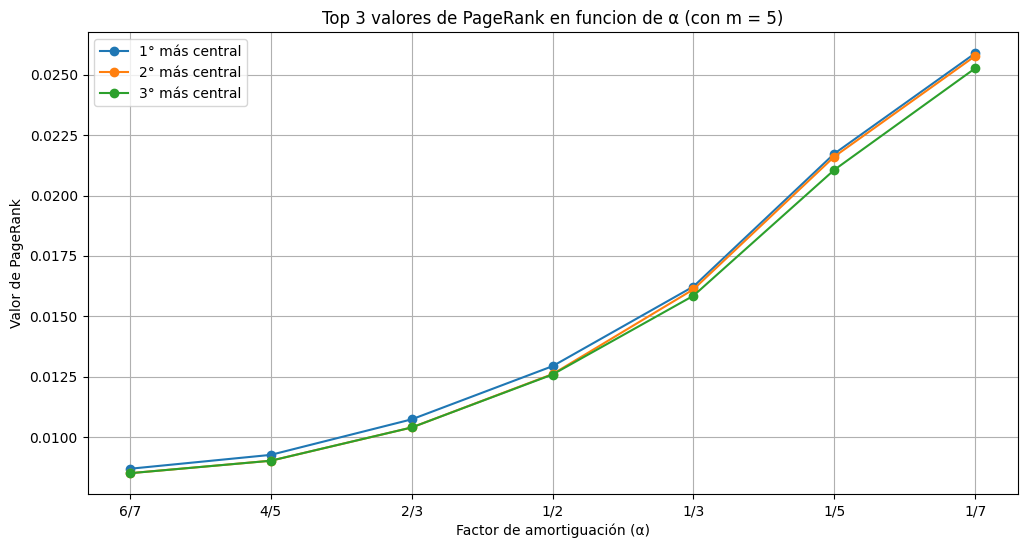

In [246]:
# Ahora en función de alfa

plt.figure(figsize=(12,6))
plt.plot(valores_alfa, top1_alfa, marker='o', label='1° más central')
plt.plot(valores_alfa, top2_alfa, marker='o', label='2° más central')
plt.plot(valores_alfa, top3_alfa, marker='o', label='3° más central')
plt.xlabel("Factor de amortiguación (α)")
plt.ylabel("Valor de PageRank")
plt.title("Top 3 valores de PageRank en funcion de α (con m = 5)")
plt.grid(True)
plt.legend()
plt.show()

Con toda esta información podemos ver que las posiciones en el ranking varían de forma notoria al modificar tanto el número de conexiones ($m$) como el valor del factor de amortiguación ($\alpha$). Se observa que ningún museo se mantiene siempre en la misma posición, y que algunos desaparecen del Top 3 completamente al cambiar los parámetros.

En cuanto a los patrones observados, cuando $m = 1$, los museos más importantes son el **#65**, **#107** y **#34**. Esto sugiere que estos museos tienen un rol destacado en redes muy locales, donde cada nodo solo se conecta con su vecino más cercano. A medida que se aumenta el número de conexiones, aparecen otros museos en el top, como el **#117** y **#125** con $m = 3$ y  $m = 5$, y más adelante, con $m = 10$, el top 3 cambia completamente, destacándose el **#124**, **#135** y **#15**.

Esto indica que hay museos que sólo son relevantes cuando la red es más desconectada, mientras que otros se vuelven más centrales cuando la red es más densa. Por ejemplo, el museo **#125** aparece varias veces, lo cual sugiere que tiene una buena posición dentro de la red en general.
Ahora, cuando analizamos el efecto de variar $\alpha$, lo primero que se observa es que cuando $\alpha$ es alto los valores de $p$ son mucho más bajos, es decir, cuando las caminatas aleatorias son más cortas y hay mayor probabilidad de reiniciar desde un nodo al azar. En este caso destaca el museo **#107**.

Sin embargo, cuando $\alpha$ disminuye (lo que implica caminatas más largas), el museo **#93** comienza a ocupar el primer lugar, seguido por el **#125** y el **#117**. Esto sugiere que esos museos se benefician de estar en posiciones que reciben muchas visitas indirectas cuando las caminatas se extienden.

El análisis muestra que el ranking de PageRank es sensible tanto a la estructura de la red como a los parámetros elegidos. Algunos museos, como el **#107**, son importantes cuando las visitas son más aleatorias, mientras que otros (como el **#93**) ganan importancia cuando las visitas siguen caminos más largos dentro de la red.

También se ve que el número de conexiones por museo $m$ tiene un impacto fuerte en qué museos se destacan: redes más locales tienden a favorecer nodos periféricos con buena conectividad inmediata, mientras que redes más densas tienden a beneficiar a los nodos mejor posicionados globalmente.
Se observa que en general, la importancia de los museos es más pareja cuando $m$ crece. y cuando está más cerca de $1$ que de $0$.

-------

En cuanto al análisis de los gráficos, podemos observar lo siguiente:
Al aumentar $\alpha$, el efecto del reinicio aleatorio se vuelve más fuerte, y por lo tanto, todos los museos tienen casi la misma importancia (tamaño del nodo en el gráfico) ya que si $\alpha = 1$ todos los museos tienen la misma probabilidad de ser elegidos.

Sin embargo, al disminuir $\alpha$ (por ejemplo, a $1/5$ o $1/7$), las caminatas se hacen más largas, y el PageRank tiende a concentrarse más en museos ubicados en zonas densamente conectadas, especialmente en el centro geográfico de CABA.


Cuando $m$ es pequeño (por ejemplo, $m = 1$), los museos más relevantes tienden a estar aislados pero bien posicionados localmente, es decir, tienen vecinos cercanos que los eligen como los más próximos. Esto genera centralidad en zonas periféricas o menos densas, donde hay poca competencia por conexiones.

A medida que $m$ aumenta, la red se vuelve más densa y ganan aún más protagonismo los museos ubicados en zonas con alta concentración de nodos. En particular, se observa una fuerte concentración de PageRank en el centro y norte de la ciudad, donde la conectividad es mayor.

## Punto 4:


Si $V_{0}$ es la distribución inicial, o cantidad inicial de visitantes en cada museo, y considero la matriz C, entonces para un elemento i cualquiera de $CV_{0}$, tengo que i = $c_{1,i}*v_{1} + c_{2,i}*v_{2} + \ldots + c_{n,i}*v_{n}$ que no es otra cosa que la suma de la cantidad de visitantes que cada museo distinto del i (si i=j $c_{ij} = 0$) le aporta al i.

De forma análoga pero partiendo de otra cantidad inicial $V_{1} = CV_{0}$ nos dara la cantidad de visitantes por museo luego de 2 pasos.
Al final, como menciona el tip, $C^{k}V_{0} = V_{k}$ nos dara la cantida de visitantes por museo luego de k pasos.

Dada la matriz $B$ y $V_{0}$ tengo que: $Bv_{0} = C^{0}v_{0} + C^{1}v_{0} + \ldots + C^{r-1}v_{0}$. Por lo mencionado antes, resulta que, por ejemplo: $C^{0}v_{0} + C^{1}v_{0}$ será la cantidad total de gente que visitó cada museo luego de dos pasos.
En general $C^{0}v_{0} + C^{1}v_{0} + \ldots + C^{r-1}v_{0}$ da la totalidad de visitantes por museo, es decir, w, luego de k pasos.
Si asumo la existencia de $B^{-1}$, para cada r, entonces para cada total de visitantes por museo w tengo la distribución inicial $V_{0}$ que lo generó.

## Punto 5:

Usando la ecuación  

$$
\mathbf{v} = B^{-1} \mathbf{w}
$$

y suponiendo que las personas dan \( $r = 3$ \) pasos en la red de museos, calcular la cantidad total de visitantes que entraron en la red, $
\|\mathbf{v}\|_1 $
, a partir del vector $ \mathbf{w}\ $ provisto en el archivo `visitas.txt`. Usar para esto la matriz de transiciones definida por la ecuación:

$$
C_{ji} = P(i \to j) = \frac{f(d_{ij})}{\sum_{k=1,\, k \ne i}^{N} f(d_{ik})}
$$


Para esto:

- Construya una función `calcula_matriz_C_continua` que reciba la matriz de distancias entre museos $ D $ y retorne la matriz $ C $ definida en la ecuación anterior.
- Construya una función `calcula_B(C, r)` que reciba la matriz $ C $ y el número de pasos $ r $ como argumento, y retorne la matriz $
\mathbf{v} = B^{-1} \mathbf{w}
$.
- Utilice la función `calculaLU` para resolver la ecuación:

$$
\mathbf{v} = B^{-1} \mathbf{w}
$$

In [ ]:
w = np.loadtxt("visitas.txt") #Arma vector w a partir del archivo
C = tf.calcula_matriz_C_continua(D) # Construye la matriz de transiciones C
B = tf.calcula_B(C, 3) # Calcula la matriz B que representa la relación entre el total de visitas y el número inicial de visitantes suponiendo que cada visitante realizó 3 pasos
v = tf.resolver_con_LU(B, w)

visitantes_totales = np.sum(np.abs(v)) # Calcula norma 1 de v
print(visitantes_totales)

c:\Users\mazze\OneDrive\Documentos\GIT\ALC2025-1c-TP1\template_funciones.py:91: RuntimeWarning: divide by zero encountered in divide
  F = 1/D


136605.0


## Punto 6:

Supongan que se enteran de que el número total de visitantes por museo $ \mathbf{w} $ tiene un error del 5%, y necesitan estimar cómo se propaga ese error a la estimación del número inicial $ \mathbf{v} $ de visitantes. Llamemos $ \tilde{\mathbf{w}} $ y $ \tilde{\mathbf{v}} $ los valores reales para el total de visitas y el total de primeras visitas respectivamente.

Si expresamos este problema usando el número de condición, tenemos que:

$$
\frac{\|\mathbf{v} - \tilde{\mathbf{v}}\|_1}{\|\mathbf{v}\|_1} \leq \text{cond}_1(B) \cdot \frac{\|\mathbf{w} - \tilde{\mathbf{w}}\|_1}{\|\mathbf{w}\|_1}
$$

Calcule el número de condición de $ B $ y estime la cota para el error de estimación de $ \mathbf{v} $.

In [ ]:
cond_B = tf.condicion_1_por_LU(B)# Número de condición de B
error_v = cond_B * 0.05 # La cota para el error de estimación de v

print(cond_B)
print(error_v)

5.051771176665004
0.2525885588332502


# Extras

Para graficar la red con un conjunto de puntajes (como el Page Rank)

{0: Text(4924405.086723215, 6160838.106023658, ''),
 1: Text(4917216.80489522, 6166701.553530234, ''),
 2: Text(4924486.298584606, 6161409.256658559, ''),
 3: Text(4921922.052887296, 6164690.544542129, ''),
 4: Text(4920636.67547965, 6165640.199444978, ''),
 5: Text(4925338.320928778, 6162016.528710163, ''),
 6: Text(4922856.100832731, 6163868.567721188, '6'),
 7: Text(4922641.894255253, 6162355.100129171, ''),
 8: Text(4917938.7521918025, 6168273.372961773, ''),
 9: Text(4924683.52693892, 6158996.617208998, ''),
 10: Text(4925725.9600755945, 6160896.846339954, ''),
 11: Text(4922075.10183836, 6164294.738410278, ''),
 12: Text(4926038.146946977, 6159721.190876993, ''),
 13: Text(4925200.592014585, 6161503.005610317, ''),
 14: Text(4925229.168803978, 6160973.145341254, ''),
 15: Text(4924875.410406244, 6161061.981187101, ''),
 16: Text(4924474.294424794, 6161547.549492302, ''),
 17: Text(4923553.755484842, 6163571.336254905, ''),
 18: Text(4924615.955668659, 6160843.2491330765, ''),
 19

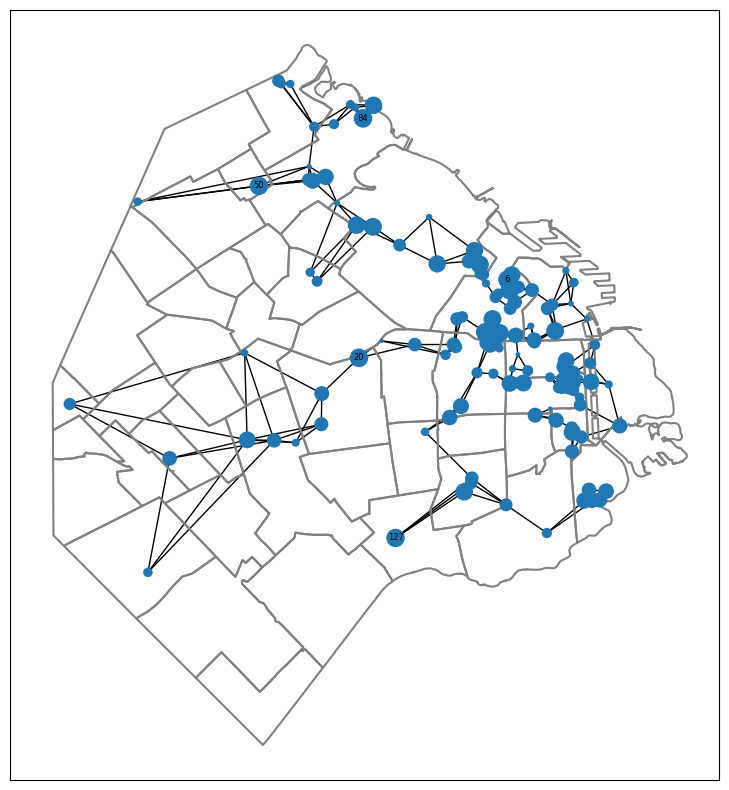

In [249]:
factor_escala = 1e4 # Escalamos los nodos 10 mil veces para que sean bien visibles
fig, ax = plt.subplots(figsize=(10, 10)) # Visualización de la red en el mapa
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
pr = np.random.uniform(0,1,museos.shape[0])# Este va a ser su score Page Rank. Ahora lo reemplazamos con un vector al azar
pr = pr/pr.sum() # Normalizamos para que sume 1
Nprincipales = 5 # Cantidad de principales
principales = np.argsort(pr)[-Nprincipales:] # Identificamos a los N principales
labels = {n: str(n) if i in principales else "" for i, n in enumerate(G.nodes)} # Nombres para esos nodos
nx.draw_networkx(G,G_layout,node_size = pr*factor_escala, ax=ax,with_labels=False) # Graficamos red
nx.draw_networkx_labels(G, G_layout, labels=labels, font_size=6, font_color="k") # Agregamos los nombres